# **READ ME** 📖
---
> Author  : [Adithya Vikram Raj Garoju](mailto:adithyagaroju96@gmail.com) 📧

> Date: 10th May 2022 📅

      Steps:
      1. ELK logs are transformed accordingly to accomodate more data comparatively in lesser rows and columns. 
          *   Segregated data Metric wise
          *   Merged them based on hostname inspite of timestamp


      2. Based on Correlation (pearson coefficient) if any columns correlation factor is greater than 0.95 they can be excluded.

      3. Performed following clustering techniques:
            *   Gausian Mixture Model
                - chosen n_components based on AIC and BIC trend.
            *   DBSCAN
                - started out with randome eps and min_samples.
            *   Isolation Forest
                - Chosen 5% contamination factor.

      4. The better fit algorithm for current scenario among the above would be Isolation Forest classifier .
          *  Due to comparitively low hyper-parameters to choose.
          * Isolation Forest stands out when compared to both DBSCAN and GMM, since both of them follow Expectation Maximization Approach.
          * Additionally we are not opting to segement given hosts to various classes we primarily want to deal with anomolies, we can skip to choose components or min_samples instead focusing on contamination factor.
          * The data traffic is expected to receive for every 15 mins for finding host outliers.
          * Isolation Forest would be a good fit for online model deployement due to its model persistence and it doesnt need to train every time unlike DBSCAN. We can predict new instances and recommend outliers.
          * Also GMM would do but we need to choose n_components all the time which is not relevant at this point of time.
          * We can utilize the warm_start param and update our model with new set of log data to prevent our model from getting stale. 
          (Also catching up with moore's law 😉)





# Imports & Inputs

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import random
import joblib

import sklearn
# from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest

import warnings
warnings.filterwarnings(action='ignore')

import seaborn as sns; sns.set()

In [ ]:
INPUT_FILE_PATH = "/content/drive/MyDrive/Take-Home Assignments/Unsupervised/data/unsupervised-NML_challenge-data.csv"
INPUT_FILE_DESC_PATH = "/content/drive/MyDrive/Take-Home Assignments/Unsupervised/data/unsupervised-NML_challenge-field_descriptions.csv"

data = pd.read_csv(INPUT_FILE_PATH)
data_desc = pd.read_csv(INPUT_FILE_DESC_PATH)

## Raw Data

1. **ELK logs** dataset contains samples from **388** hosts.

2. Each Metric holds data points which are significant features.
  * *Total Processes* 
    * procs
  * *CPU Utilization*
    * cpuuser
    * cpusystem
    * cpuiowait
    * cpuidle
    * cpunice
    * cpusteal
  * *Load per Core* 
    * load1
    * load5
    * load15

In [ ]:
data.head()

,timestamp,hostname: Descending,description: Descending,avg1,avg2,avg3,avg4,avg5,avg6,avg7,avg8,avg9,avg10,avg11,avg12,avg13
0,1630051200000,host_0,System - Total Processes,1381.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1630051200000,host_1,System - Total Processes,1066.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1630051200000,host_2,System - CPU Utilization,0.444,0.312,0.070,99.176,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1630051200000,host_2,System - Load per core,0.004,0.005,0.007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1630051200000,host_4,System - Total Processes,1439.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data_desc.head()

,description,perfdata.key1,perfdata.key2,perfdata.key3,perfdata.key4,perfdata.key5,perfdata.key6,perfdata.key7,perfdata.key8,perfdata.key9,perfdata.key10,perfdata.key11,perfdata.key12,perfdata.key13
0,System - CPU Utilization,cpuuser,cpusystem,cpuiowait,cpuidle,cpunice,cpusteal,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,System - Load per core,load1,load5,load15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,System - Total Processes,procs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Data Preparation

In [ ]:
### Missing values
def miss_hit_ratio(df,title=None):
  data_miss = df.isnull().sum().sort_values(ascending=False)/len(data)
  data_miss *= 100
  data_hit = (100-data_miss)
  #----------------
  labels = data_miss.index.sort_values()
  # Stacked Bar Plot

  WIDTH = 0.35

  fig, ax  = plt.subplots()
  fig.set_size_inches(18.5,10.5)
  ax.bar(labels,data_miss, WIDTH, label='Miss')
  ax.bar(labels,data_hit, WIDTH,label='Hit',bottom=data_miss)
  ax.legend()
  plt.xticks(rotation=45)
  if title is not None:
    plt.title(title,fontsize=40)
  plt.show()

In [ ]:
data_desc = data_desc[data_desc.columns[:7]] #Considering valid columns only! columns from perfdata.key7 to perfdata.key13 does not provide any valuable information

data = data[data.columns[1:9]] # In the similar fashion columns from avg7 to avg13 are complete missing values
data.rename(columns={'hostname: Descending':'hostname','description: Descending':'description'},inplace=True)
data.head() #avg7 to avg13 are complete missing values can eliminate them

,hostname,description,avg1,avg2,avg3,avg4,avg5,avg6
0,host_0,System - Total Processes,1381.000,NaN,NaN,NaN,NaN,NaN
1,host_1,System - Total Processes,1066.000,NaN,NaN,NaN,NaN,NaN
2,host_2,System - CPU Utilization,0.444,0.312,0.070,99.176,0.0,0.0
3,host_2,System - Load per core,0.004,0.005,0.007,NaN,NaN,NaN
4,host_4,System - Total Processes,1439.000,NaN,NaN,NaN,NaN,NaN


In [ ]:
print("Shape of data before transformation", data.shape, "and their missing values in total", data.isna().sum().sum())

Shape of data before transformation (1541, 8) and their missing values in total 5837


**Metric Nomenclature**

Since the meta data has been provided, lets make use of more detailed column names! 

In [ ]:
for df in (data,data_desc):
  df.description = df.description.str.replace('System - ','') # Removing redundant words
  df.description = df.description.str.replace(' ','_').str.lower() # Replace Spaces with underscore

In [ ]:
total_processes =  data[data.description=='total_processes']
cpu_utilization = data[data.description=='cpu_utilization']
load_per_core = data[data.description=='load_per_core']
#---------------------
for df in (total_processes, cpu_utilization, load_per_core):
  _description = df.description.unique()[0]
  cols = data_desc[data_desc.description == _description].dropna(axis=1).values#.tolist()
  cols = cols.tolist()[0][1:]
  print(_description,' -> ',cols)
  cols = ['hostname'] + cols
  df.drop('description',axis=1,inplace=True)
  df.reset_index(drop=True,inplace=True)
  df.rename(columns=dict(zip(df.columns,cols)),inplace=True)
  df.drop(df.columns[~df.columns.isin(cols)],axis=1,inplace=True)

total_processes  ->  ['procs']
cpu_utilization  ->  ['cpuuser', 'cpusystem', 'cpuiowait', 'cpuidle', 'cpunice', 'cpusteal']
load_per_core  ->  ['load1', 'load5', 'load15']


### Merging Metric Subsets

In [ ]:
transformed_data = pd.merge(cpu_utilization,total_processes,on='hostname')
transformed_data = pd.merge(transformed_data,load_per_core,on='hostname')
transformed_data.fillna(0,inplace=True)
transformed_data.describe()

,cpuuser,cpusystem,cpuiowait,cpuidle,cpunice,cpusteal,procs,load1,load5,load15
count,477.000000,477.000000,477.000000,477.000000,477.000000,477.0,477.000000,477.000000,477.000000,477.000000
mean,2.184256,0.482256,0.030382,96.365681,0.097589,0.0,1589.119497,0.030826,0.028281,0.029040
std,3.790489,0.560518,0.100366,9.936728,0.323540,0.0,455.342018,0.051085,0.046079,0.046771
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,0.216000,0.124000,0.000000,95.572000,0.000000,0.0,1368.000000,0.003000,0.003000,0.003000
50%,0.384000,0.166000,0.002000,99.278000,0.000000,0.0,1396.000000,0.007000,0.007000,0.007000
75%,3.342000,0.626000,0.018000,99.654000,0.002000,0.0,1656.000000,0.043000,0.039000,0.042000
max,40.262000,2.524000,0.666000,99.810000,3.048000,0.0,4131.000000,0.415000,0.416000,0.413000


In [ ]:
print("Shape of transformed data", transformed_data.shape)
print("No of Eliminated False Missing Values", data.shape[0]+data.shape[1]-transformed_data.shape[0]+transformed_data.shape[1])

Shape of transformed data (477, 11)
No of Eliminated False Missing Values 1083


In [ ]:
# Scaling is required because the procs is very much high when compared to any other field
transformed_data.drop('cpusteal',axis=1,inplace=True) # since no useful contribution to predict anything - just adds extra memory to process

In [ ]:
# transformed_data[transformed_data.columns[1]]
# miss_hit_ratio(transformed_data,title="Effect of Transformation")

In [ ]:
transformed_data

,hostname,cpuuser,cpusystem,cpuiowait,cpuidle,cpunice,procs,load1,load5,load15
0,host_2,0.444,0.312,0.070,99.176,0.000,1448.0,0.004,0.005,0.007
1,host_9,0.204,0.108,0.000,99.688,0.000,1355.0,0.002,0.002,0.003
2,host_9,0.204,0.108,0.000,99.688,0.000,1342.0,0.002,0.002,0.003
3,host_14,0.232,0.118,0.000,99.648,0.000,1362.0,0.002,0.002,0.002
4,host_14,0.232,0.118,0.000,99.648,0.000,1362.0,0.001,0.001,0.002
...,...,...,...,...,...,...,...,...,...,...
472,host_347,2.422,1.188,0.034,96.210,0.146,4040.0,0.083,0.061,0.066
473,host_363,5.716,1.232,0.024,89.982,3.048,2601.0,0.155,0.117,0.089
474,host_373,9.268,2.332,0.278,87.958,0.168,2826.0,0.131,0.104,0.110
475,host_388,0.608,0.174,0.026,99.192,0.000,1402.0,0.004,0.005,0.004


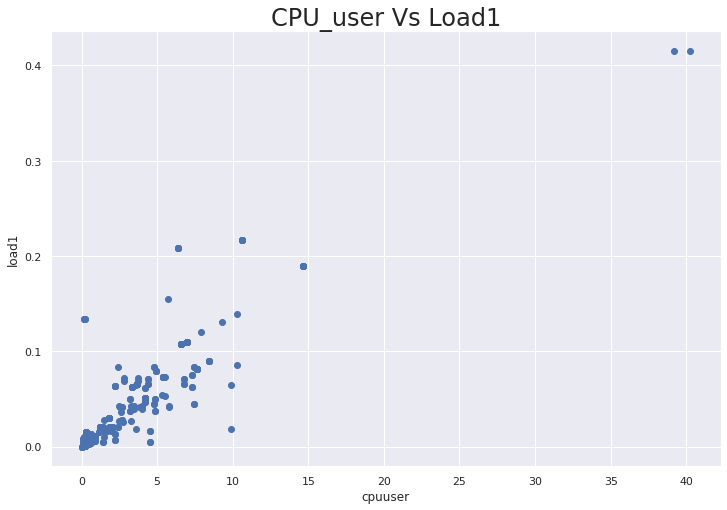

In [ ]:
## showcase correlation matrix and 9x9  scatter matrix
fig, ax = plt.subplots(figsize=(12,8))#, dpi = 300
x,y='cpuuser','load1'
plt.scatter(transformed_data[x],transformed_data[y])
plt.title('CPU_user Vs Load1',fontsize=24)
plt.xlabel(x)
plt.ylabel(y)
plt.savefig('user_load.png',dpi=300)
plt.show()

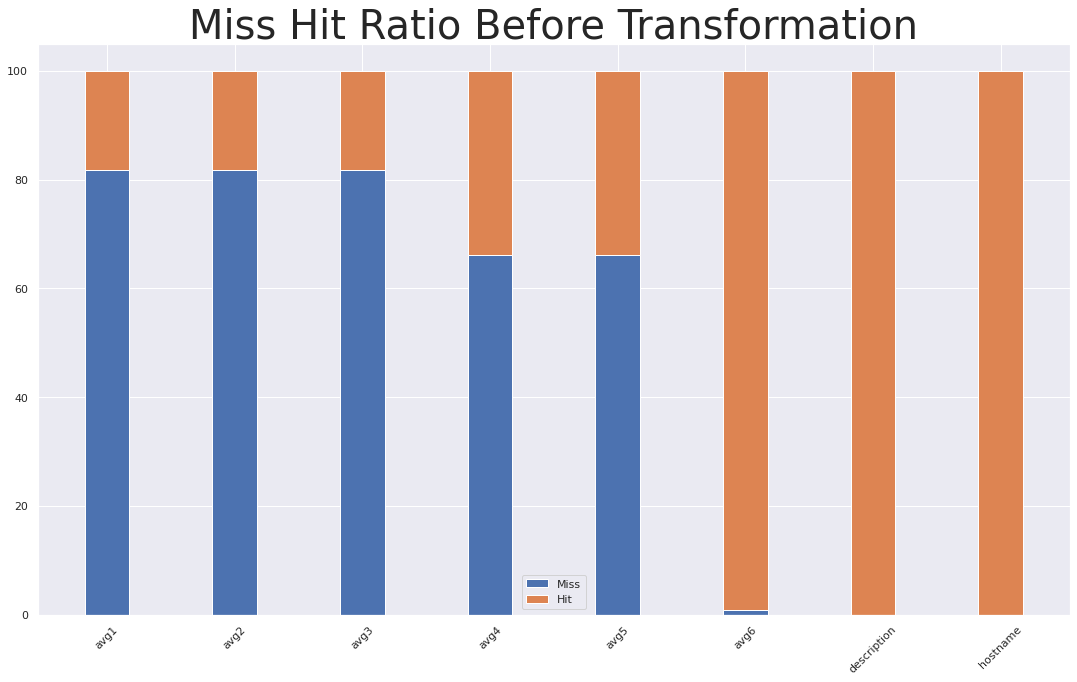

In [ ]:
miss_hit_ratio(data,title='Miss Hit Ratio Before Transformation')

# Exploratory Data Analysis

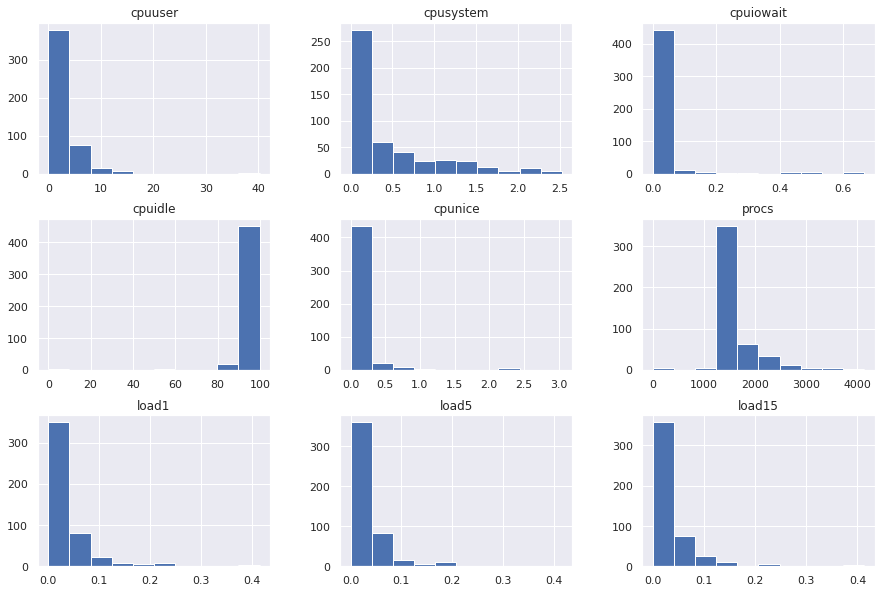

In [ ]:
transformed_data.hist(bins=10, figsize=(15, 10))
plt.savefig('histograms.png',dpi=300)
plt.show()

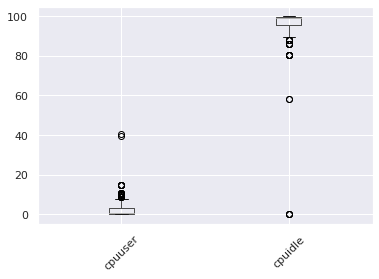

In [ ]:
transformed_data[['cpuuser','cpuidle']].boxplot()

plt.xticks(rotation=45)
plt.savefig('box-user-idle.png',dpi=300, bbox_inches = "tight")
plt.show()

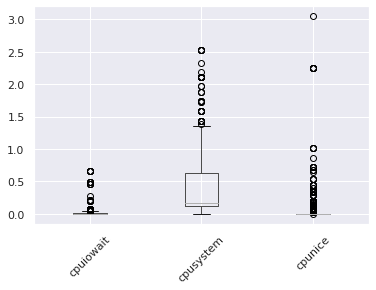

In [ ]:
transformed_data[['cpuiowait','cpusystem','cpunice']].boxplot() #'cpuiowait','cpunice'

plt.xticks(rotation=45)
plt.savefig('box-iowait-system-nice.png',dpi=300, bbox_inches = "tight")
plt.show()

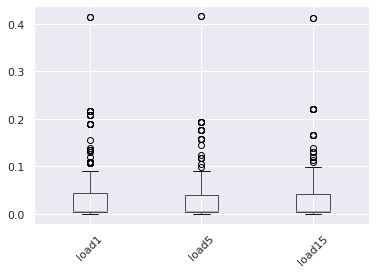

In [ ]:
transformed_data[['load1','load5','load15',]].boxplot()

plt.xticks(rotation=45)
plt.savefig('box-load1-5-15.png',dpi=300, bbox_inches = "tight")
plt.show()

### Excluding strongly correlated values 

Since, They do not contribute in prediction

[]

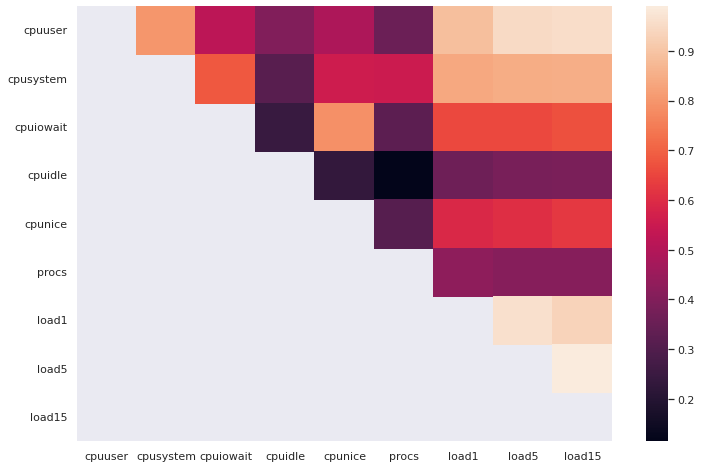

In [ ]:
corr_matrix = transformed_data.corr().abs()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

threshold = 0.95
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

transformed_data.drop(to_drop,axis=1,inplace=True)

plt.figure(figsize=(12, 8))
sns.heatmap(upper)
plt.savefig('correlation.png',dpi=300)
plt.plot()

In [ ]:
to_drop

['load5', 'load15']

# Clustering

### Train Data Generation

In [ ]:
train_data = transformed_data.drop('hostname',axis=1).fillna(0) #Since its a null value

scaler = StandardScaler()
train_data = scaler.fit_transform(train_data) #X
train_data.shape

(477, 7)

### Dimensionality Reduction

In [ ]:
# Using The reduced training set for Visualization
pca = PCA(n_components = 2)
reduced_training_data = pca.fit_transform(train_data)

print(pca.explained_variance_ratio_,pca.singular_values_)

[0.59044872 0.16204545] [44.4016698  23.26090627]


In [ ]:
# from sklearn.cluster import KMeans
# k = 5
# kmeans= KMeans(n_clusters=k,random_state=42)
# y_pred = kmeans.fit_predict(train_data)
# len(y_pred)

### DBSCAN

In [ ]:
dbscan = DBSCAN(eps=0.5, min_samples=2)
dbscan.fit(train_data)

DBSCAN(min_samples=2)

In [ ]:
set(dbscan.labels_)

In [ ]:
len(dbscan.core_sample_indices_)
transformed_data['DBSCAN_anomalies'] = pd.Series(dbscan.labels_).apply(lambda x: 1 if x!=-1 else -1)

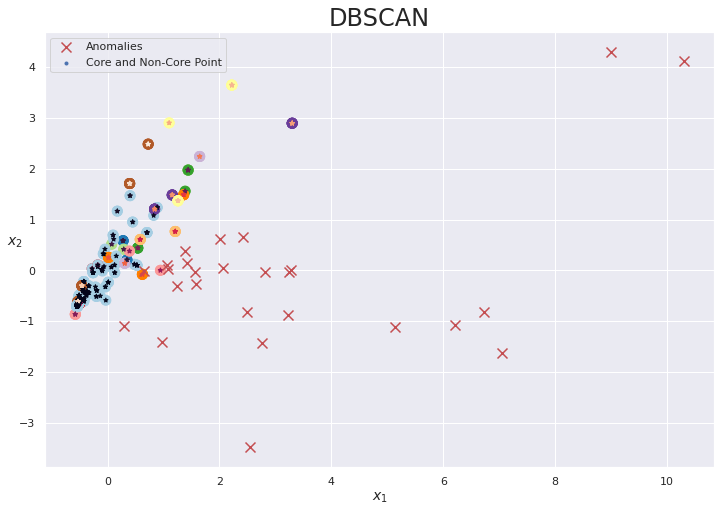

In [ ]:
plt.figure(figsize=(12, 8))
X = reduced_training_data
size=100
core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
core_mask[dbscan.core_sample_indices_] = True
anomalies_mask = dbscan.labels_ == -1
non_core_mask = ~(core_mask | anomalies_mask)

cores = dbscan.components_
anomalies = X[anomalies_mask]
non_cores = X[non_core_mask]

plt.scatter(cores[:, 0], cores[:, 1],
            c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
plt.scatter(anomalies[:, 0], anomalies[:, 1],
            c="r", marker="x", s=100, label='Anomalies')
plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".", label='Core and Non-Core Point')
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.title("DBSCAN",fontsize=24)
plt.legend()
plt.savefig('DBSCAN.png',dpi=300)
plt.show()

### GMM

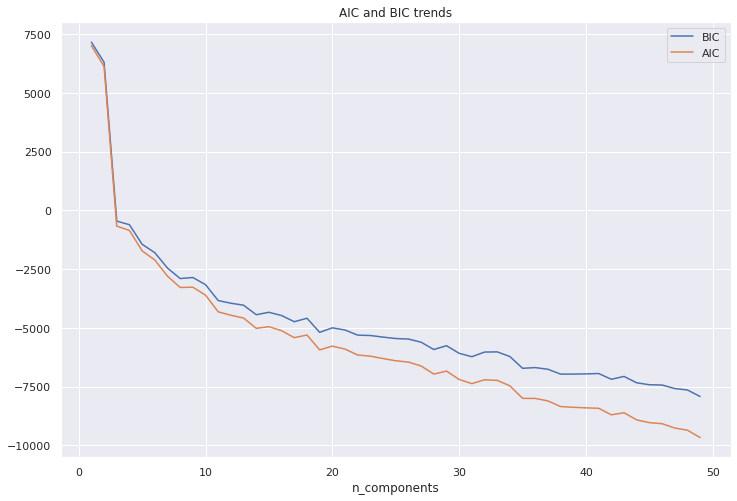

In [ ]:
n_components = np.arange(1,50)

models = [GaussianMixture(n, covariance_type='tied', n_init=10,random_state=42).fit(train_data)
          for n in n_components]
          

plt.figure(figsize=(12, 8))
plt.title("AIC and BIC trends")
plt.plot(n_components, [m.bic(train_data) for m in models], label='BIC')
plt.plot(n_components, [m.aic(train_data) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');
plt.show()

In [ ]:
## GMM
gmm = GaussianMixture(n_components=2,covariance_type="tied",n_init=10, random_state=42).fit(train_data)
labels = gmm.predict(train_data)

In [ ]:
(gmm.converged_,gmm.n_iter_)

(True, 4)

In [ ]:
# Generating sample data
# X_new, y_new = gmm.sample(2)
# X_new,y_new

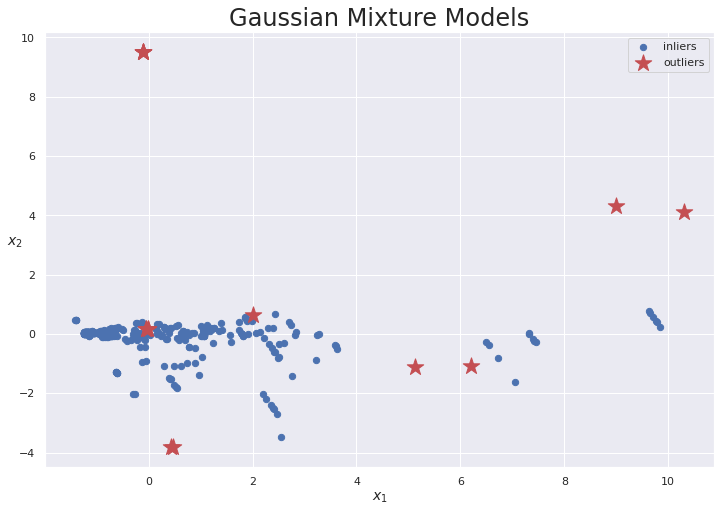

In [ ]:
densities = gmm.score_samples(train_data)

density_threshold = np.percentile(densities,3)
anomalies = reduced_training_data[densities < density_threshold]

plt.figure(figsize=(12, 8))
plt.scatter(reduced_training_data[:,0],reduced_training_data[:,1],s=40,cmap='viridis',label='inliers'); #c=labels,
plt.scatter(anomalies[:,0], anomalies[:,1], s=300,color='r', marker='*',label='outliers');
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.title("Gaussian Mixture Models",fontsize=24)
plt.legend(loc='best')
plt.savefig('gausian_mixture_model.png',dpi=300)
plt.show()

In [ ]:
transformed_data['gmm_anomalies'] = pd.Series(labels).apply(lambda x: -1 if x!=1 else 1)
transformed_data

,hostname,cpuuser,cpusystem,cpuiowait,cpuidle,cpunice,procs,load1,DBSCAN_anomalies,gmm_anomalies
0,host_2,0.444,0.312,0.070,99.176,0.000,1448.0,0.004,1,-1
1,host_9,0.204,0.108,0.000,99.688,0.000,1355.0,0.002,1,-1
2,host_9,0.204,0.108,0.000,99.688,0.000,1342.0,0.002,1,-1
3,host_14,0.232,0.118,0.000,99.648,0.000,1362.0,0.002,1,-1
4,host_14,0.232,0.118,0.000,99.648,0.000,1362.0,0.001,1,-1
...,...,...,...,...,...,...,...,...,...,...
472,host_347,2.422,1.188,0.034,96.210,0.146,4040.0,0.083,-1,-1
473,host_363,5.716,1.232,0.024,89.982,3.048,2601.0,0.155,-1,-1
474,host_373,9.268,2.332,0.278,87.958,0.168,2826.0,0.131,-1,-1
475,host_388,0.608,0.174,0.026,99.192,0.000,1402.0,0.004,1,-1


## Isolation forest

In [ ]:
clf = IsolationForest(n_estimators = 100, max_samples='auto',contamination = float(0.05),max_features=1.0,bootstrap = False,n_jobs = -1, random_state=42)
clf.fit(train_data)
labels = clf.predict(train_data)

In [ ]:
transformed_data['isolation_forest_anomalies'] = labels
outlier_index = list(transformed_data.loc[transformed_data['isolation_forest_anomalies']==-1].index)

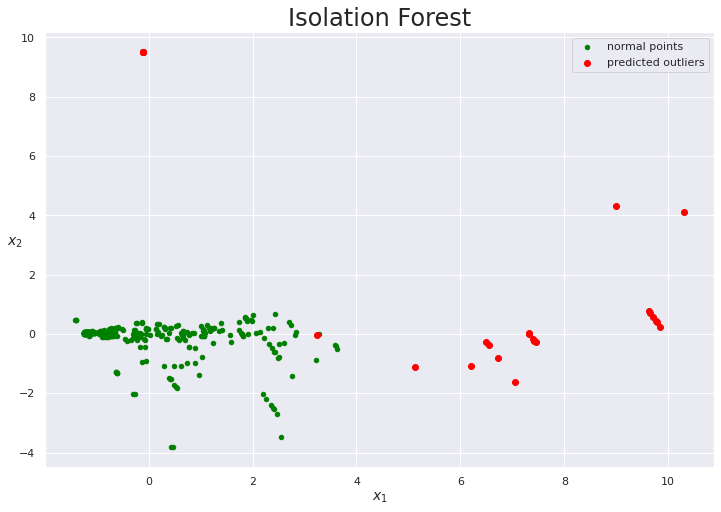

In [ ]:
res = pd.DataFrame(reduced_training_data)
Z = np.array(res)
plt.figure(figsize=(12, 8))
plt.title("Isolation Forest",fontsize=24)

b1=plt.scatter(res[0],res[1],
               c='green',s=20,label='normal points')
b1=plt.scatter(res.iloc[outlier_index,0],res.iloc[outlier_index,1],
               c='red', label='predicted outliers')
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.legend(loc='upper right')
plt.savefig('Isolation_Forest.png',dpi=300)
plt.show()

## Host Anomalies

In [ ]:
transformed_data

,hostname,cpuuser,cpusystem,cpuiowait,cpuidle,cpunice,procs,load1,DBSCAN_anomalies,gmm_anomalies,isolation_forest_anomalies
0,host_2,0.444,0.312,0.070,99.176,0.000,1448.0,0.004,1,-1,1
1,host_9,0.204,0.108,0.000,99.688,0.000,1355.0,0.002,1,-1,1
2,host_9,0.204,0.108,0.000,99.688,0.000,1342.0,0.002,1,-1,1
3,host_14,0.232,0.118,0.000,99.648,0.000,1362.0,0.002,1,-1,1
4,host_14,0.232,0.118,0.000,99.648,0.000,1362.0,0.001,1,-1,1
...,...,...,...,...,...,...,...,...,...,...,...
472,host_347,2.422,1.188,0.034,96.210,0.146,4040.0,0.083,-1,-1,1
473,host_363,5.716,1.232,0.024,89.982,3.048,2601.0,0.155,-1,-1,-1
474,host_373,9.268,2.332,0.278,87.958,0.168,2826.0,0.131,-1,-1,-1
475,host_388,0.608,0.174,0.026,99.192,0.000,1402.0,0.004,1,-1,1


In [ ]:
# Considering only isolation_forest_anomalies
list(transformed_data[transformed_data.isolation_forest_anomalies==-1].hostname.unique())

['host_312',
 'host_341',
 'host_238',
 'host_201',
 'host_209',
 'host_220',
 'host_363',
 'host_373']

In [ ]:
list(transformed_data[transformed_data.DBSCAN_anomalies==-1].hostname.unique())

['host_156',
 'host_194',
 'host_341',
 'host_238',
 'host_215',
 'host_87',
 'host_125',
 'host_136',
 'host_147',
 'host_159',
 'host_209',
 'host_237',
 'host_347',
 'host_363',
 'host_373']

In [ ]:
list(transformed_data[transformed_data.gmm_anomalies==-1].hostname.unique())

['host_2',
 'host_9',
 'host_14',
 'host_22',
 'host_29',
 'host_30',
 'host_50',
 'host_84',
 'host_95',
 'host_111',
 'host_135',
 'host_143',
 'host_156',
 'host_161',
 'host_166',
 'host_179',
 'host_194',
 'host_195',
 'host_211',
 'host_216',
 'host_222',
 'host_234',
 'host_245',
 'host_248',
 'host_256',
 'host_257',
 'host_268',
 'host_273',
 'host_289',
 'host_7',
 'host_18',
 'host_31',
 'host_33',
 'host_312',
 'host_46',
 'host_78',
 'host_91',
 'host_99',
 'host_322',
 'host_325',
 'host_332',
 'host_333',
 'host_184',
 'host_188',
 'host_199',
 'host_204',
 'host_238',
 'host_250',
 'host_267',
 'host_300',
 'host_309',
 'host_86',
 'host_154',
 'host_187',
 'host_336',
 'host_215',
 'host_218',
 'host_259',
 'host_264',
 'host_5',
 'host_34',
 'host_35',
 'host_37',
 'host_43',
 'host_45',
 'host_47',
 'host_49',
 'host_51',
 'host_52',
 'host_54',
 'host_56',
 'host_59',
 'host_63',
 'host_76',
 'host_87',
 'host_98',
 'host_114',
 'host_124',
 'host_125',
 'host_136',